<a href="https://colab.research.google.com/github/nuriamontala/PYT-SBI/blob/main/Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric
#!pip install graphein

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [ ]:
import torch
import torch.nn as nx
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_add_pool
from torch_geometric.data import Data
import graphein.protein as gp
from graphein.protein.config import ProteinGraphConfig
from Bio import PDB
import os
from torch_geometric.data import Data, Dataset
from torch.utils.data import Dataset, random_split, Subset
import pandas as pd
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions,
                                             add_delaunay_triangulation)

# Edge construction functions
new_edge_funcs = {"edge_construction_functions": [
    add_peptide_bonds,
    add_aromatic_interactions,
    add_hydrogen_bond_interactions,
    add_disulfide_interactions,
    add_ionic_interactions,
    add_aromatic_sulphur_interactions,
    add_cation_pi_interactions,
    add_delaunay_triangulation
]}


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LOAD RESIDUE FEATURES

In [ ]:
from graphein.protein.graphs import construct_graph

# ✅ Load Residue Features from CSV
def load_residue_features(csv_path):
    """Loads residue features and binding site labels from CSV."""
    df = pd.read_csv(csv_path)

    # Convert first column (Residue ID) into tuples (residue_number, chain)
    df.iloc[:, 0] = df.iloc[:, 0].apply(eval)  # Convert string "(1, 'L')" → tuple (1, 'L')

    residue_ids = df.iloc[:, 0]  # Residue ID as tuple
    features = df.iloc[:, 1:-1].values  # Feature columns (excluding label)
    labels = df.iloc[:, -1].values  # Last column = binding site labels

    # Create lookup dictionaries
    features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}
    labels_dict = {res_id: label for res_id, label in zip(residue_ids, labels)}

    return features_dict, labels_dict, features.shape[1]  # Return num_features



CONVERT GRAPHEIN TO PYTORCH GEOMETRIC OBJECT

In [ ]:
# ✅ Convert NetworkX Graph → PyTorch Geometric Graph
def networkx_to_pyg(G_nx, features_dict, labels_dict, num_features):
    """Converts a NetworkX protein graph to a PyTorch Geometric Data object, removing nodes without features."""
    node_map = {}  # Maps node (residue, chain) to index
    reverse_map = {}  # Reverse lookup: PyG index → (residue_number, chain)
    node_features = []
    y = []
    valid_nodes = set()  # Stores nodes that have valid features

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_id = (attr.get("residue_number"), attr.get("chain_id"))  # Standardized format

        # Only include nodes that have valid features
        if res_id not in features_dict:
            continue  # Skip nodes with missing features

        valid_nodes.add(node)
        node_map[node] = len(node_features)  # Assign PyG-compatible node index
        reverse_map[len(node_features)] = res_id  # Store mapping back to residue identifier

        # Retrieve features
        node_features.append(features_dict[res_id])

        # Retrieve binding site labels
        y.append(labels_dict.get(res_id, 0))

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    # Extract edges but only keep edges where **both** nodes are in valid_nodes
    edges = []
    for u, v in G_nx.edges():
        if u in valid_nodes and v in valid_nodes:  # Ensure both nodes exist in the filtered set
            edges.append((node_map[u], node_map[v]))

    if not edges:  # If no valid edges, return None (to avoid empty graphs)
        print(f"⚠️ Graph contains no valid edges after filtering. Skipping!")
        return None, None

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=y), reverse_map


PROCESS ALL PDB + CSV FILES IN A FOLDER

In [ ]:
from torch_geometric.data import Dataset

def process_protein_graphs(folder_path, save_path="protein_graphs", start=0, end=500):
    """Processes PDB files in batches of 500 and saves graphs with PDB codes as filenames."""
    os.makedirs(save_path, exist_ok=True)  # Create output folder if it doesn't exist

    # Get all available PDB files
    pdb_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".pdb")])  # Sort for consistency

    # Select a subset (batch of 500)
    pdb_files = pdb_files[start:end]

    for pdb_file in pdb_files:
        pdb_code = pdb_file.replace(".pdb", "")  # Extract PDB code
        pdb_path = os.path.join(folder_path, pdb_file)
        csv_path = os.path.join(folder_path, pdb_code + ".csv")
        graph_file = os.path.join(save_path, f"{pdb_code}.pt")  # Use PDB code as filename

        # ✅ Skip if the graph file already exists (avoid overwriting)
        if os.path.exists(graph_file):
            print(f"⚠️ Graph for {pdb_code} already exists. Skipping!")
            continue

        if not os.path.exists(csv_path):
            print(f"⚠️ Warning: No CSV found for {pdb_file}. Skipping!")
            continue

        print(f"📌 Processing {pdb_file}...")

        # Load features & labels
        features_dict, labels_dict, num_features = load_residue_features(csv_path)

        # Construct NetworkX graph
        config = ProteinGraphConfig(**new_edge_funcs)
        G_nx = construct_graph(config=config, path=pdb_path)

        # Convert to PyG Data object
        protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, labels_dict, num_features)

        if protein_graph_data:  # Ensure we have a valid graph
            torch.save((data, reverse_map), graph_file)
            print(f"✅ Saved graph as {graph_file}")

    print(f"✅ Batch {start}-{end} processed and saved in {save_path}")

# ✅ Run
process_protein_graphs("testingfiles/testingfiles", start=0, end=500)


FileNotFoundError: [Errno 2] No such file or directory: 'testingfiles/testingfiles'

El bloque de a continuación es porque he tenido problemas para cargar correctamente pytorch geometric así que lo reinstalo

In [ ]:
# 🔄 Reinstalar desde cero (con versión de PyTorch compatible con Colab)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch-geometric

In [ ]:
!unzip -o "/content/drive/MyDrive/SBI_PYT_def/graphs/protein_graphs.zip" -d "/content/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/protein_graphs/4j79.pt  
  inflating: /content/protein_graphs/4j7i.pt  
  inflating: /content/protein_graphs/4j81.pt  
  inflating: /content/protein_graphs/4j82.pt  
  inflating: /content/protein_graphs/4j84.pt  
  inflating: /content/protein_graphs/4j86.pt  
  inflating: /content/protein_graphs/4j8b.pt  
  inflating: /content/protein_graphs/4j8g.pt  
  inflating: /content/protein_graphs/4j8s.pt  
  inflating: /content/protein_graphs/4j8t.pt  
  inflating: /content/protein_graphs/4jai.pt  
  inflating: /content/protein_graphs/4jaj.pt  
  inflating: /content/protein_graphs/4jaz.pt  
  inflating: /content/protein_graphs/4jbo.pt  
  inflating: /content/protein_graphs/4jbp.pt  
  inflating: /content/protein_graphs/4jbs.pt  
  inflating: /content/protein_graphs/4jc1.pt  
  inflating: /content/protein_graphs/4jck.pt  
  inflating: /content/protein_graphs/4jda.pt  
  inflating: /content/protein_graphs/4jdf.pt  
  inflati

In [ ]:
!ls -lh /content


total 112K
drwx------ 7 root root 4.0K Apr  1 10:06 drive
drwxr-xr-x 2 root root 104K Apr  1 10:17 protein_graphs
drwxr-xr-x 1 root root 4.0K Mar 28 13:39 sample_data


In [ ]:
from torch_geometric.data import DataLoader
import torch
from torch_geometric.data import Dataset

# ✅ Define PyTorch Geometric Dataset
class LazyProteinDataset(Dataset):
    """Lazy dataset that loads graphs from disk one at a time."""
    def __init__(self, graph_folder):
        self.graph_folder = graph_folder
        self.graph_files = [os.path.join(graph_folder, f) for f in os.listdir(graph_folder) if f.endswith(".pt")]

    def __len__(self):  # ✅ Correctly defined __len__()
        return len(self.graph_files)

    def __getitem__(self, idx):  # ✅ Fix: Use __getitem__() instead of get()
        return torch.load(self.graph_files[idx])  # Load graph from disk



# ✅ Load Dataset from Saved Graphs
graph_folder = "/content/protein_graphs"  # Set the folder where graphs were saved
protein_graph_dataset = LazyProteinDataset(graph_folder)

# ✅ Split dataset into train/test
train_size = int(0.8 * len(protein_graph_dataset))
test_size = len(protein_graph_dataset) - train_size

indices = list(range(len(protein_graph_dataset)))
train_indices, test_indices = torch.utils.data.random_split(indices, [train_size, test_size])

train_dataset = Subset(protein_graph_dataset, train_indices)
test_dataset = Subset(protein_graph_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

TRAINING BLACKBOX

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv
import pandas as pd
import os
import torch.nn.functional as F  # Import softmax

# ✅ Extend Dataset class to handle protein graphs
class ProteinGraphDataset(Dataset):
    def __init__(self, graph_folder):
        self.graph_folder = graph_folder
        self.graph_files = [os.path.join(graph_folder, f) for f in os.listdir(graph_folder) if f.endswith(".pt")]

    def __len__(self):
        return len(self.graph_files)

    def __getitem__(self, idx):
        return torch.load(self.graph_files[idx], weights_only=False)

# ✅ Create Virtual Node GAT Model
class GATVirtualNode(nn.Module):
    def __init__(self, in_features, hidden_dim, num_heads, num_classes, dropout=0.2):
        super(GATVirtualNode, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Virtual Node (Global Graph Representation)
        self.virtual_node_embedding = nn.Parameter(torch.zeros(1, hidden_dim))

        # Graph Attention Layers
        self.gat1 = GATConv(in_features, hidden_dim // num_heads, heads=num_heads)
        self.gat2 = GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads)

        # MLP Classifier for **node classification**
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),  # Add dropout here
            nn.Linear(hidden_dim // 2, num_classes)  # Output for **each node**
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply first GAT layer
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Apply second GAT layer
        x = self.gat2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Virtual Node Aggregation
        virtual_node = self.virtual_node_embedding.expand(x.size(0), -1)
        x = x + virtual_node

        # **Return node-level predictions**
        return self.mlp(x)  # Output has same shape as `data.y`

# ✅ Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


Import Drive content

TRAINING PART

In [ ]:
import torch
from torch.serialization import add_safe_class

from torch_geometric.data.data import Data, DataEdgeAttr
add_safe_class(Data)
add_safe_class(DataEdgeAttr)


ImportError: cannot import name 'add_safe_class' from 'torch.serialization' (/usr/local/lib/python3.11/dist-packages/torch/serialization.py)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/50 - Loss: 0.6773, Validation Accuracy: 0.4805
✅ Model saved at epoch 1 with accuracy 0.4805!
Epoch 2/50 - Loss: 0.6593, Validation Accuracy: 0.5881
✅ Model saved at epoch 2 with accuracy 0.5881!
Epoch 3/50 - Loss: 0.6512, Validation Accuracy: 0.6389
✅ Model saved at epoch 3 with accuracy 0.6389!
Epoch 4/50 - Loss: 0.6446, Validation Accuracy: 0.6260
Epoch 5/50 - Loss: 0.6396, Validation Accuracy: 0.6080
Epoch 6/50 - Loss: 0.6365, Validation Accuracy: 0.6581
✅ Model saved at epoch 6 with accuracy 0.6581!
Epoch 7/50 - Loss: 0.6347, Validation Accuracy: 0.6002
Epoch 8/50 - Loss: 0.6328, Validation Accuracy: 0.6299
Epoch 9/50 - Loss: 0.6315, Validation Accuracy: 0.5964
Epoch 10/50 - Loss: 0.6294, Validation Accuracy: 0.6242
Epoch 11/50 - Loss: 0.6281, Validation Accuracy: 0.6412
Epoch 12/50 - Loss: 0.6274, Validation Accuracy: 0.6698
✅ Model saved at epoch 12 with accuracy 0.6698!
Epoch 13/50 - Loss: 0.6276, Validation Accuracy: 0.6457
Early stopping
✅ Training Completed!


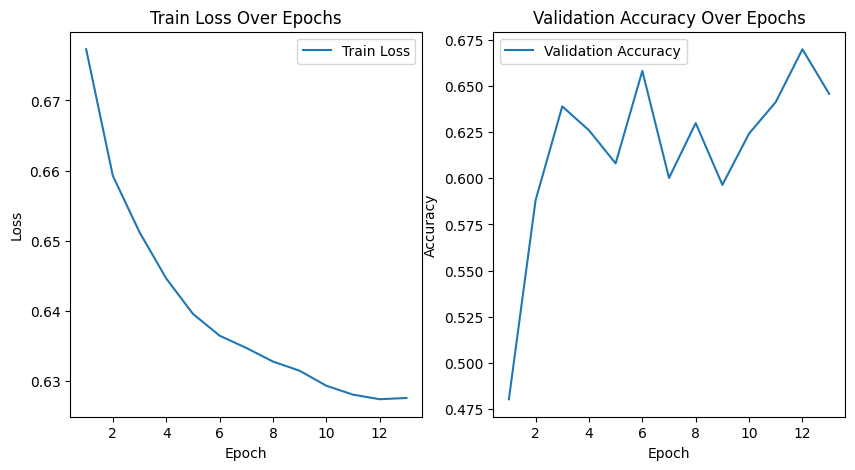

🎯 Final Test Accuracy: 0.6478


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch_geometric.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from collections import Counter

# ✅ Train the model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data)  # Output shape: (num_nodes, num_classes)
        loss = criterion(out, data.y)  # Cross-entropy loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

# ✅ Evaluate the model
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)

            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

    return correct / total  # Node-level accuracy

# ✅ Load Protein Dataset
# protein_graph_dataset = ProteinGraphDataset(protein_graph_dataset)  # Wrap list into PyG Dataset
protein_graph_dataset = ProteinGraphDataset(graph_folder) # Pass the graph_folder to ProteinGraphDataset

# ✅ Split dataset into train/validation/test (70% train, 10% val, 20% test)
train_size = int(0.7 * len(protein_graph_dataset))
val_size = int(0.1 * len(protein_graph_dataset))
test_size = len(protein_graph_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(protein_graph_dataset, [train_size, val_size, test_size])

# ✅ Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# ✅ Define Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GATVirtualNode(in_features=protein_graph_dataset[0].x.shape[1], hidden_dim=128, num_heads=4, num_classes=2).to(device)

# **Balanced Class Weights** (based on Counter({0: 1375603, 1: 204152}))
class_weights = torch.tensor([1.0, 1375603 / 204152], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)  # Lowered learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce lr every 5 epochs

model_save_path = "trained_gat_model.pth"

# ✅ Training Loop (with validation & early stopping)
num_epochs = 50
best_val_acc = 0.0
early_stopping = EarlyStopping(patience=5, delta=0.01)

train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_acc = evaluate(model, val_loader, device)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # ✅ Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Model saved at epoch {epoch+1} with accuracy {val_acc:.4f}!")

    scheduler.step()  # Adjust learning rate

    # Check for early stopping (now based on validation loss)
    early_stopping(train_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model after training
early_stopping.load_best_model(model)
print("✅ Training Completed!")

# ✅ Plot Loss vs. Accuracy Trends
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Over Epochs")

plt.show()

# ✅ Final Test Evaluation
test_acc = evaluate(model, test_loader, device)
print(f"🎯 Final Test Accuracy: {test_acc:.4f}")



TESTING BLACKBOX

In [ ]:
import torch
import os
import pandas as pd
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from torch_geometric.data import Data
import torch.nn.functional as F  # Import softmax

# ✅ Load Residue Features from CSV (without labels)
def load_residue_features(csv_path):
    """Loads residue features (without labels) from CSV."""
    df = pd.read_csv(csv_path)
    df.iloc[:, 0] = df.iloc[:, 0].apply(eval)  # Convert "(1, 'L')" → (1, 'L')

    residue_ids = df.iloc[:, 0]  # Residue ID as tuple
    features = df.iloc[:, 1:].values  # Feature columns (WITHOUT label)

    # Create lookup dictionary
    features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}

    return features_dict, features.shape[1]  # Return features & number of features

# ✅ Convert NetworkX Graph → PyTorch Geometric Graph
def networkx_to_pyg(G_nx, features_dict, num_features):
    """Converts a NetworkX protein graph to a PyTorch Geometric Data object."""
    node_map = {}
    reverse_map = {}
    node_features = []

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_id = (attr.get("residue_number"), attr.get("chain_id"))
        node_map[node] = i
        reverse_map[i] = res_id

        features = features_dict.get(res_id, [0] * num_features)  # Use zero vector if missing
        node_features.append(features)

    x = torch.tensor(node_features, dtype=torch.float)

    edges = [(node_map[u], node_map[v]) for u, v in G_nx.edges() if u in node_map and v in node_map]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index), reverse_map

# ✅ Function to Predict Binding Sites with Probabilities
def predict_binding_sites(model, pdb_path, csv_path, device):
    """Predicts binding sites for a single PDB file using a trained model and returns probabilities."""
    model.eval()

    if not os.path.exists(csv_path):
        print(f"⚠️ No CSV found for {pdb_path}. Skipping!")
        return None

    print(f"📌 Processing {pdb_path}...")

    # Load features
    features_dict, num_features = load_residue_features(csv_path)

    # Construct graph
    config = ProteinGraphConfig(**new_edge_funcs)  # Ensure new_edge_funcs is defined
    G_nx = construct_graph(config=config, path=pdb_path)

    # Convert to PyG format
    protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, num_features)

    # Move to device
    protein_graph_data = protein_graph_data.to(device)

    # Make prediction
    with torch.no_grad():
        out = model(protein_graph_data)  # Shape: (num_nodes, num_classes)
        probabilities = F.softmax(out, dim=1)[:, 1]  # Probability of class 1 (binding site)

    # Map probabilities to residue IDs
    binding_site_probabilities = {
        reverse_map[i]: float(probabilities[i].item()) for i in range(len(probabilities))
    }

    return binding_site_probabilities

# ✅ Load Trained Model
model_path = "trained_gat_model.pth"  # CHANGE THIS to your model path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Load dynamic in_features based on dataset
pdb_file = "6afj.pdb"  # CHANGE THIS
csv_file = "6afj.csv"  # CHANGE THIS

# Load residue features to get the correct input size
features_dict, num_features = load_residue_features(csv_file)  # Get correct input size

# ✅ Initialize Model (using correct feature size)
model = GATVirtualNode(
    in_features=num_features, hidden_dim=128, num_heads=4, num_classes=2
).to(device)

# Load the trained model state
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ Inference on a New PDB + CSV (with probabilities)
binding_site_probs = predict_binding_sites(model, pdb_file, csv_file, device)

# ✅ Print Results
if binding_site_probs is not None:
    print("\n🔹 Binding Site Probability Predictions 🔹")
    for residue, prob in binding_site_probs.items():
        print(f"Residue {residue}: Probability of Binding Site = {prob:.4f}")
else:
    print("⚠️ No binding site probabilities to display.")

FileNotFoundError: [Errno 2] No such file or directory: '6afj.csv'

In [ ]:
DEBUGGING AND OTHER STUFF

In [ ]:
!rm -rf /content/protein_graphs  # Remove incorrectly extracted folder
!unzip -o "/content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip" -d "/content/"


Archive:  /content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip
   creating: /content/protein_graphs/
  inflating: /content/protein_graphs/1g5f.pt  
  inflating: /content/protein_graphs/5ayy.pt  
  inflating: /content/protein_graphs/5gn7.pt  
  inflating: /content/protein_graphs/5ewd.pt  
  inflating: /content/protein_graphs/2ql9.pt  
  inflating: /content/protein_graphs/1lqd.pt  
  inflating: /content/protein_graphs/2mps.pt  
  inflating: /content/protein_graphs/5tl9.pt  
  inflating: /content/protein_graphs/1tsl.pt  
  inflating: /content/protein_graphs/4fns.pt  
  inflating: /content/protein_graphs/5azg.pt  
  inflating: /content/protein_graphs/3sv7.pt  
  inflating: /content/protein_graphs/13gs.pt  
  inflating: /content/protein_graphs/4lxb.pt  
  inflating: /content/protein_graphs/6eq4.pt  
  inflating: /content/protein_graphs/2jjr.pt  
  inflating: /content/protein_graphs/3gqo.pt  
  inflating: /content/protein_graphs/4tw6.pt  
  inflating: /content/protein_graphs/5ew

In [ ]:
import os
print("Extracted files:", os.listdir("/content/protein_graphs"))


Extracted files: ['5tkt.pt', '4s3e.pt', '3twr.pt', '3kxz.pt', '3lik.pt', '4ipf.pt', '3muf.pt', '1lt5.pt', '5acx.pt', '1h1b.pt', '5l99.pt', '1cqp.pt', '5d1n.pt', '6cbh.pt', '1oq5.pt', '5bpe.pt', '3t1l.pt', '4drn.pt', '3n2c.pt', '4m5m.pt', '2cbr.pt', '2n0u.pt', '5tbj.pt', '4bbe.pt', '4k72.pt', '2jk9.pt', '4fe9.pt', '2x4s.pt', '5mri.pt', '4lq9.pt', '5l4f.pt', '3qlc.pt', '3vi5.pt', '1guw.pt', '4pz5.pt', '3wk8.pt', '2uw3.pt', '5wbr.pt', '3at1.pt', '2hd6.pt', '1z3j.pt', '5tzx.pt', '5qaz.pt', '5khi.pt', '6b30.pt', '1lhg.pt', '5tl9.pt', '5alm.pt', '3bxs.pt', '4iu0.pt', '3agm.pt', '4c5w.pt', '2oph.pt', '4qr5.pt', '3zpt.pt', '4bfz.pt', '6qae.pt', '4e49.pt', '3mxc.pt', '1m5f.pt', '1i80.pt', '5i22.pt', '4o75.pt', '1rpa.pt', '6eea.pt', '1mqd.pt', '3tkz.pt', '3chp.pt', '3s9t.pt', '6eo8.pt', '3vb7.pt', '3g76.pt', '5g11.pt', '4ii9.pt', '4rx5.pt', '6cvx.pt', '6mm5.pt', '1zaj.pt', '3kyg.pt', '6f6u.pt', '1swk.pt', '3plu.pt', '1tog.pt', '4b6e.pt', '5tnt.pt', '1rek.pt', '1agm.pt', '3twx.pt', '5nmg.pt', '5j

CHECKING FOR CLASS IMABLANCE

In [ ]:
from collections import Counter
labels = [data.y.tolist() for data in protein_graph_dataset]
flattened_labels = [y for sublist in labels for y in sublist]
print(Counter(flattened_labels))  # Show class counts

<ipython-input-18-6cdf9eafee65>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.graph_files[idx])  # Load graph from disk


Counter({0: 1375603, 1: 204152})


A PARTIR D'ACÍ, VAIG POSANT LES MILLORES QUE M'HA DIT CLAUDE

In [ ]:
!unzip -o "/content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip" -d "/content/"

Archive:  /content/drive/MyDrive/MÁSTER/SBIPYTPLProject/protein_graphs.zip
  inflating: /content/protein_graphs/1g5f.pt  
  inflating: /content/protein_graphs/5ayy.pt  
  inflating: /content/protein_graphs/5gn7.pt  
  inflating: /content/protein_graphs/5ewd.pt  
  inflating: /content/protein_graphs/2ql9.pt  
  inflating: /content/protein_graphs/1lqd.pt  
  inflating: /content/protein_graphs/2mps.pt  
  inflating: /content/protein_graphs/5tl9.pt  
  inflating: /content/protein_graphs/1tsl.pt  
  inflating: /content/protein_graphs/4fns.pt  
  inflating: /content/protein_graphs/5azg.pt  
  inflating: /content/protein_graphs/3sv7.pt  
  inflating: /content/protein_graphs/13gs.pt  
  inflating: /content/protein_graphs/4lxb.pt  
  inflating: /content/protein_graphs/6eq4.pt  
  inflating: /content/protein_graphs/2jjr.pt  
  inflating: /content/protein_graphs/3gqo.pt  
  inflating: /content/protein_graphs/4tw6.pt  
  inflating: /content/protein_graphs/5ewh.pt  
  inflating: /content/protein_g

LOADING AND SPLITTING CLAUDE

In [ ]:
##AQUI

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv
import pandas as pd
import os
import torch.nn.functional as F  # Import softmax

# ✅ Extend Dataset class to handle protein graphs
class ProteinGraphDataset(Dataset):
    def __init__(self, graph_folder):
        self.graph_folder = graph_folder
        self.graph_files = [os.path.join(graph_folder, f) for f in os.listdir(graph_folder) if f.endswith(".pt")]

    def __len__(self):
        return len(self.graph_files)

    def __getitem__(self, idx):
        return torch.load(self.graph_files[idx], weights_only=False)

# ✅ Create Virtual Node GAT Model
class GATVirtualNode(nn.Module):
    def __init__(self, in_features, hidden_dim, num_heads, num_classes, dropout=0.2):
        super(GATVirtualNode, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # Virtual Node (Global Graph Representation)
        self.virtual_node_embedding = nn.Parameter(torch.zeros(1, hidden_dim))

        # Graph Attention Layers
        self.gat1 = GATConv(in_features, hidden_dim // num_heads, heads=num_heads)
        self.gat2 = GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads)

        # MLP Classifier for **node classification**
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),  # Add dropout here
            nn.Linear(hidden_dim // 2, num_classes)  # Output for **each node**
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply first GAT layer
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Apply second GAT layer
        x = self.gat2(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)

        # Virtual Node Aggregation
        virtual_node = self.virtual_node_embedding.expand(x.size(0), -1)
        x = x + virtual_node

        # **Return node-level predictions**
        return self.mlp(x)  # Output has same shape as `data.y`

# ✅ Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.9 MB/s eta 0:00:00


TRAINING CLAUDE

Here are the things Claude says that have been improved:
This improved implementation addresses all the issues I mentioned:

Virtual Node Implementation: The ImprovedGATVirtualNode class now properly implements the virtual node mechanism with message passing between nodes and the virtual node.
Attention Mechanism: The model now captures and stores attention weights, allowing for interpretability.
Early Stopping: The ImprovedEarlyStopping class now properly monitors validation metrics and can handle both minimizing and maximizing metrics.
Class Imbalance Handling: Added FocalLoss class for better handling of imbalanced data.
Evaluation Metrics: The evaluate_model function computes comprehensive metrics including accuracy, precision, recall, F1-score, and AUC-ROC.
Feature Importance Analysis: Added analyze_feature_importance function to interpret which node features contribute most to predictions.
Batch Normalization: Added optional batch normalization between layers.
Residual Connections: Implemented skip connections for better gradient flow.
K-fold Cross-Validation: Added kfold_cross_validation function for more robust model evaluation.
Model Interpretability: Added methods to extract and analyze attention weights.

This improved code should significantly enhance your protein-ligand binding site prediction model's performance and interpretability.

In [ ]:
!python -c "import torch; print(torch.__version__)"


2.6.0+cu124


In [ ]:
# Uninstall current versions
!pip uninstall torch torch-scatter torch-sparse torch-geometric torch-cluster torch-spline-conv -y

# Install PyTorch 2.2.0 + CUDA 11.8
!pip install torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install PyTorch Geometric dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html

# Finally, install torch-geometric
!pip install torch-geometric


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torch-geometric 2.6.1
Uninstalling torch-geometric-2.6.1:
  Successfully uninstalled torch-geometric-2.6.1
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.7/811.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 80.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 8.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.0/903.0 kB 2.4 MB/s eta 0:00:00
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import GATConv
from torch_scatter import scatter_mean, scatter_sum
import pandas as pd
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Improved Dataset class with statistics and class weight calculation
class ProteinGraphDataset(Dataset):
    def __init__(self, graph_folder, transform=None, pre_transform=None, pre_filter=None, cache_data=False):
        super().__init__(transform, pre_transform, pre_filter)
        self.graph_folder = graph_folder
        self.graph_files = [os.path.join(graph_folder, f) for f in os.listdir(graph_folder) if f.endswith(".pt")]

        # Optional caching for faster access
        self.cache_data = cache_data
        self._cache = {}

    def __len__(self):
        return len(self.graph_files)

    def __getitem__(self, idx):
        if self.cache_data and idx in self._cache:
            return self._cache[idx]

        try:
            data = torch.load(self.graph_files[idx])

            # Ensure batch attribute exists for virtual node implementation
            if not hasattr(data, 'batch') or data.batch is None:
                data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

            # Apply any transforms
            if self.transform is not None:
                data = self.transform(data)

            # Cache if enabled
            if self.cache_data:
                self._cache[idx] = data

            return data
        except Exception as e:
            print(f"Error loading file {self.graph_files[idx]}: {e}")
            raise

    def get_class_weights(self):
        """Calculate class weights for handling imbalanced data."""
        all_labels = []
        for i in range(min(100, len(self))):  # Sample for efficiency
            data = self[i]
            all_labels.extend(data.y.tolist())

        # Count occurrences of each class
        label_counts = np.bincount(all_labels)
        n_samples = len(all_labels)
        n_classes = len(label_counts)

        # Weighted inversely proportional to class frequencies
        weights = n_samples / (n_classes * label_counts)
        return torch.FloatTensor(weights)


# Improved Virtual Node GAT Model with proper message passing
class ImprovedGATVirtualNode(nn.Module):
    def __init__(self, in_features, hidden_dim, num_heads, num_classes, dropout=0.2,
                 residual=True, batch_norm=True):
        super(ImprovedGATVirtualNode, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.residual = residual
        self.batch_norm = batch_norm

        # Virtual node embedding
        self.virtual_node_embedding = nn.Parameter(torch.zeros(1, hidden_dim))

        # Virtual node update MLP
        self.virtual_node_mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Graph Attention Layers
        self.gat1 = GATConv(in_features, hidden_dim // num_heads, heads=num_heads)
        self.gat2 = GATConv(hidden_dim, hidden_dim // num_heads, heads=num_heads)

        # Node-to-virtual message passing
        self.node_to_virtual = nn.Linear(hidden_dim, hidden_dim)

        # Virtual-to-node message passing
        self.virtual_to_node = nn.Linear(hidden_dim, hidden_dim)

        # MLP Classifier for node classification
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Optional BatchNorm layers
        if batch_norm:
            self.bn1 = nn.BatchNorm1d(hidden_dim)
            self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(dropout)

        # Store attention weights for interpretability
        self.attention_weights = None

    def reset_parameters(self):
        """Reset all learnable parameters."""
        if hasattr(self, 'bn1'):
            self.bn1.reset_parameters()
            self.bn2.reset_parameters()

        self.gat1.reset_parameters()
        self.gat2.reset_parameters()

        # Reset virtual node embedding
        nn.init.zeros_(self.virtual_node_embedding)

        # Reset MLP layers
        for layer in self.virtual_node_mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        self.node_to_virtual.reset_parameters()
        self.virtual_to_node.reset_parameters()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Ensure batch tensor exists
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        # Get number of graphs in batch
        num_graphs = batch.max().item() + 1

        # Virtual node initial state
        virtual_node = self.virtual_node_embedding.expand(num_graphs, -1)

        # First GAT layer with attention weights capture
        x1, attention_weights1 = self.gat1(x, edge_index, return_attention_weights=True)
        x1 = F.relu(x1)

        if self.batch_norm:
            x1 = self.bn1(x1)

        x1 = self.dropout(x1)

        # Virtual node aggregation (nodes → virtual)
        virtual_node_temp = scatter_mean(self.node_to_virtual(x1), batch, dim=0)
        virtual_node = virtual_node + self.virtual_node_mlp(virtual_node_temp)

        # Virtual node messaging (virtual → nodes)
        virtual_node_features = self.virtual_to_node(virtual_node)[batch]

        # Add virtual node features to node embeddings
        x1 = x1 + virtual_node_features

        # Second GAT layer
        x2, attention_weights2 = self.gat2(x1, edge_index, return_attention_weights=True)

        # Store attention weights for interpretability
        self.attention_weights = (attention_weights1, attention_weights2)

        x2 = F.relu(x2)

        if self.batch_norm:
            x2 = self.bn2(x2)

        x2 = self.dropout(x2)

        # Residual connection if enabled
        if self.residual and x.size(1) == self.hidden_dim:
            x2 = x2 + x

        # Final node classification
        out = self.mlp(x2)

        return out

    def get_attention_weights(self):
        """Return attention weights for interpretability."""
        return self.attention_weights


# Improved Early Stopping with validation metrics monitoring
class ImprovedEarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=True, path='best_model.pt', metric_name='val_loss',
                 mode='min'):
        """
        Args:
            patience: Number of epochs with no improvement
            delta: Minimum change in monitored quantity to qualify as improvement
            verbose: If True, prints a message for each improvement
            path: Path to save the best model
            metric_name: Name of the metric to monitor
            mode: 'min' or 'max' (whether to minimize or maximize the metric)
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.metric_name = metric_name
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

        # Set the appropriate comparison function
        self.improved = self._improvement_func()

    def _improvement_func(self):
        """Return the appropriate improvement function based on mode."""
        if self.mode == 'min':
            return lambda current, best: current < best - self.delta
        else:  # mode == 'max'
            return lambda current, best: current > best + self.delta

    def __call__(self, metrics, model):
        """
        Args:
            metrics: Dictionary of metrics
            model: Model to save
        """
        current = metrics[self.metric_name]

        if self.best_score is None:
            self.best_score = current
            self.save_checkpoint(metrics, model)
        elif not self.improved(current, self.best_score):
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = current
            self.save_checkpoint(metrics, model)
            self.counter = 0

    def save_checkpoint(self, metrics, model):
        """Save model when validation performance improves."""
        if self.verbose:
            print(f'Validation {self.metric_name} {"decreased" if self.mode == "min" else "increased"} '
                  f'({self.best_score:.6f} -> {metrics[self.metric_name]:.6f}). Saving model...')

        self.best_model_state = model.state_dict()
        torch.save(self.best_model_state, self.path)

    def load_best_model(self, model):
        """Load the best model."""
        model.load_state_dict(self.best_model_state)


# Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        """
        Args:
            alpha: Weight factor for each class
            gamma: Focusing parameter
            reduction: 'none', 'mean', or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Predicted logits (before softmax)
            targets: Ground truth labels
        """
        log_probs = F.log_softmax(inputs, dim=1)
        probs = torch.exp(log_probs)

        # Get probability for the correct class
        target_probs = probs.gather(1, targets.unsqueeze(1))
        target_probs = target_probs.squeeze(1)

        # Apply focusing parameter
        focal_weight = (1 - target_probs) ** self.gamma

        # Apply class weights if provided
        if self.alpha is not None:
            focal_weight = focal_weight * self.alpha[targets]

        loss = -focal_weight * log_probs.gather(1, targets.unsqueeze(1))
        loss = loss.squeeze(1)

        if self.reduction == 'none':
            return loss
        elif self.reduction == 'mean':
            return loss.mean()
        else:  # self.reduction == 'sum'
            return loss.sum()


# Comprehensive evaluation function
def evaluate_model(model, loader, device, criterion=None):
    """Comprehensive model evaluation with multiple metrics."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)

            # Forward pass
            out = model(data)

            # Compute loss if criterion is provided
            if criterion is not None:
                loss = criterion(out, data.y)
                total_loss += loss.item() * data.num_nodes

            # Get predictions and probabilities
            probs = F.softmax(out, dim=1)
            preds = out.argmax(dim=1)

            # Store predictions, labels, and scores
            all_preds.append(preds.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
            all_scores.append(probs[:, 1].cpu().numpy())  # Probability of positive class

    # Concatenate results
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_scores = np.concatenate(all_scores)

    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_scores) if len(np.unique(all_labels)) > 1 else 0.5
    }

    # Add loss if calculated
    if criterion is not None:
        metrics['loss'] = total_loss / len(all_labels)

    return metrics


# Feature importance analysis function
def analyze_feature_importance(model, loader, device, feature_names=None):
    """Analyze feature importance using gradient-based approach."""
    model.train()  # Need gradients
    feature_gradients = []

    for data in loader:
        data = data.to(device)

        # Enable gradients for input features
        data.x.requires_grad_(True)

        # Forward pass
        out = model(data)

        # Compute gradient w.r.t positive class score
        positive_class_score = out[:, 1].sum()
        positive_class_score.backward()

        # Store gradients
        feature_gradients.append(data.x.grad.abs().mean(dim=0).cpu().numpy())

        # Reset gradients
        data.x.grad = None

    # Average gradients across batches
    avg_gradients = np.mean(feature_gradients, axis=0)

    # Create feature importance dictionary
    if feature_names is None:
        feature_names = [f"Feature_{i}" for i in range(len(avg_gradients))]

    importance_dict = dict(zip(feature_names, avg_gradients))

    # Sort by importance
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

    return sorted_importance


# K-fold cross-validation function
def kfold_cross_validation(dataset, model_class, model_kwargs, train_kwargs,
                          n_splits=5, seed=42):
    """Perform k-fold cross-validation."""
    from sklearn.model_selection import KFold

    # Initialize k-fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # Get all indices
    indices = list(range(len(dataset)))

    # Store results
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(indices)):
        print(f"Fold {fold+1}/{n_splits}")

        # Create data loaders
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        test_subset = torch.utils.data.Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=train_kwargs.get('batch_size', 8),
                                 shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=train_kwargs.get('batch_size', 8),
                                shuffle=False)

        # Initialize model
        model = model_class(**model_kwargs)

        # Train model
        # Implement your training function here
        # Define device
        device = train_kwargs.get('device', 'cuda' if torch.cuda.is_available() else 'cpu')

        # Define loss, optimizer, early stopping
        weights = dataset.get_class_weights().to(device)
        criterion = FocalLoss(alpha=weights)
        optimizer = optim.Adam(model.parameters(), lr=train_kwargs.get('lr', 1e-3))
        early_stopping = ImprovedEarlyStopping(patience=5, path=f"best_model_fold{fold}.pt", metric_name='loss', mode='min')

        # Entrenar
        model = train_model(model, train_loader, test_loader, device, criterion, optimizer, early_stopping,
                            num_epochs=train_kwargs.get('num_epochs', 50))

        # Evaluate model
        metrics = evaluate_model(model, test_loader, train_kwargs.get('device'))

        fold_results.append(metrics)

        print(f"Fold {fold+1} results: {metrics}")

    # Calculate average results
    avg_results = {k: np.mean([r[k] for r in fold_results]) for k in fold_results[0].keys()}
    std_results = {k: np.std([r[k] for r in fold_results]) for k in fold_results[0].keys()}

    print(f"Average results: {avg_results}")
    print(f"Standard deviation: {std_results}")

    return fold_results, avg_results, std_results



Faltaba por definir el training loop, se lo he pedido al chat

In [ ]:
#Faltaba por definir el training loop, se lo he pedido al chat
# Entrenamiento por épocas con validación y early stopping
def train_model(model, train_loader, val_loader, device, criterion, optimizer, early_stopping, num_epochs=50):
    """Entrena el modelo con validación y early stopping."""
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_nodes

        train_loss = total_loss / len(train_loader.dataset)

        # Evaluación en conjunto de validación
        val_metrics = evaluate_model(model, val_loader, device, criterion=criterion)
        print(f"Epoch {epoch+1:03d}: Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['loss']:.4f} | Val F1: {val_metrics['f1']:.4f}")

        # Aplicar early stopping
        early_stopping(val_metrics, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Cargar el mejor modelo guardado
    early_stopping.load_best_model(model)
    return model


LLAMAMOS A LA FUNCIÓN

In [ ]:
sample = dataset[0]
print("Shape de data.x:", sample.x.shape)


NameError: name 'dataset' is not defined

In [ ]:
dataset = ProteinGraphDataset("/content/protein_graphs")
model_class = ImprovedGATVirtualNode
model_kwargs = {
    'in_features': 68,  # ajusta según tu input
    'hidden_dim': 64,
    'num_heads': 4,
    'num_classes': 2
}
train_kwargs = {
    'batch_size': 8,
    'lr': 1e-3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_epochs': 50
}
results, avg, std = kfold_cross_validation(dataset, model_class, model_kwargs, train_kwargs)


Fold 1/5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001: Train Loss: 30.7508 | Val Loss: 0.0659 | Val F1: 0.3852
Validation loss decreased (0.065881 -> 0.065881). Saving model...
Epoch 002: Train Loss: 25.5427 | Val Loss: 0.0574 | Val F1: 0.4205
Validation loss decreased (0.057437 -> 0.057437). Saving model...
Epoch 003: Train Loss: 23.9700 | Val Loss: 0.0545 | Val F1: 0.4346
Validation loss decreased (0.054462 -> 0.054462). Saving model...
Epoch 004: Train Loss: 22.9834 | Val Loss: 0.0518 | Val F1: 0.4464
Validation loss decreased (0.051829 -> 0.051829). Saving model...
Epoch 005: Train Loss: 22.1030 | Val Loss: 0.0515 | Val F1: 0.4328
Validation loss decreased (0.051517 -> 0.051517). Saving model...
Epoch 006: Train Loss: 21.3455 | Val Loss: 0.0478 | Val F1: 0.4674
Validation loss decreased (0.047799 -> 0.047799). Saving model...
Epoch 007: Train Loss: 20.9991 | Val Loss: 0.0448 | Val F1: 0.4743
Validation loss decreased (0.044783 -> 0.044783). Saving model...
Epoch 008: Train Loss: 20.5233 | Val Loss: 0.0446 | Val F1: 0.4857
Va

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001: Train Loss: 30.2883 | Val Loss: 0.0664 | Val F1: 0.3979
Validation loss decreased (0.066356 -> 0.066356). Saving model...
Epoch 002: Train Loss: 25.3612 | Val Loss: 0.0614 | Val F1: 0.4159
Validation loss decreased (0.061385 -> 0.061385). Saving model...
Epoch 003: Train Loss: 23.6718 | Val Loss: 0.0561 | Val F1: 0.4415
Validation loss decreased (0.056056 -> 0.056056). Saving model...
Epoch 004: Train Loss: 23.0769 | Val Loss: 0.0545 | Val F1: 0.4519
Validation loss decreased (0.054471 -> 0.054471). Saving model...
Epoch 005: Train Loss: 22.0111 | Val Loss: 0.0534 | Val F1: 0.4468
Validation loss decreased (0.053424 -> 0.053424). Saving model...
Epoch 006: Train Loss: 21.6118 | Val Loss: 0.0511 | Val F1: 0.4615
Validation loss decreased (0.051083 -> 0.051083). Saving model...
Epoch 007: Train Loss: 21.1448 | Val Loss: 0.0533 | Val F1: 0.4484
EarlyStopping counter: 1 out of 5
Epoch 008: Train Loss: 20.6509 | Val Loss: 0.0493 | Val F1: 0.4691
Validation loss decreased (0.04927

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001: Train Loss: 29.9394 | Val Loss: 0.0673 | Val F1: 0.3883
Validation loss decreased (0.067335 -> 0.067335). Saving model...
Epoch 002: Train Loss: 24.7631 | Val Loss: 0.0644 | Val F1: 0.4015
Validation loss decreased (0.064447 -> 0.064447). Saving model...
Epoch 003: Train Loss: 23.1811 | Val Loss: 0.0571 | Val F1: 0.4371
Validation loss decreased (0.057090 -> 0.057090). Saving model...
Epoch 004: Train Loss: 22.2739 | Val Loss: 0.0517 | Val F1: 0.4598
Validation loss decreased (0.051740 -> 0.051740). Saving model...
Epoch 005: Train Loss: 21.4272 | Val Loss: 0.0514 | Val F1: 0.4575
Validation loss decreased (0.051420 -> 0.051420). Saving model...
Epoch 006: Train Loss: 21.0072 | Val Loss: 0.0501 | Val F1: 0.4715
Validation loss decreased (0.050068 -> 0.050068). Saving model...
Epoch 007: Train Loss: 20.5788 | Val Loss: 0.0480 | Val F1: 0.4751
Validation loss decreased (0.048016 -> 0.048016). Saving model...
Epoch 008: Train Loss: 20.0628 | Val Loss: 0.0483 | Val F1: 0.4618
Ea

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001: Train Loss: 30.3451 | Val Loss: 0.0751 | Val F1: 0.3533
Validation loss decreased (0.075114 -> 0.075114). Saving model...
Epoch 002: Train Loss: 24.7818 | Val Loss: 0.0565 | Val F1: 0.4232
Validation loss decreased (0.056536 -> 0.056536). Saving model...
Epoch 003: Train Loss: 23.2834 | Val Loss: 0.0579 | Val F1: 0.4108
EarlyStopping counter: 1 out of 5
Epoch 004: Train Loss: 22.3480 | Val Loss: 0.0541 | Val F1: 0.4294
Validation loss decreased (0.054066 -> 0.054066). Saving model...
Epoch 005: Train Loss: 21.4718 | Val Loss: 0.0531 | Val F1: 0.4310
Validation loss decreased (0.053099 -> 0.053099). Saving model...
Epoch 006: Train Loss: 20.9561 | Val Loss: 0.0505 | Val F1: 0.4486
Validation loss decreased (0.050545 -> 0.050545). Saving model...
Epoch 007: Train Loss: 20.5416 | Val Loss: 0.0487 | Val F1: 0.4650
Validation loss decreased (0.048738 -> 0.048738). Saving model...
Epoch 008: Train Loss: 20.0758 | Val Loss: 0.0525 | Val F1: 0.4260
EarlyStopping counter: 1 out of 5


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 001: Train Loss: 30.6149 | Val Loss: 0.0614 | Val F1: 0.4018
Validation loss decreased (0.061370 -> 0.061370). Saving model...
Epoch 002: Train Loss: 25.0691 | Val Loss: 0.0569 | Val F1: 0.4243
Validation loss decreased (0.056937 -> 0.056937). Saving model...
Epoch 003: Train Loss: 23.5044 | Val Loss: 0.0529 | Val F1: 0.4363
Validation loss decreased (0.052873 -> 0.052873). Saving model...
Epoch 004: Train Loss: 22.4350 | Val Loss: 0.0550 | Val F1: 0.4311
EarlyStopping counter: 1 out of 5
Epoch 005: Train Loss: 21.5070 | Val Loss: 0.0510 | Val F1: 0.4489
Validation loss decreased (0.051030 -> 0.051030). Saving model...
Epoch 006: Train Loss: 21.0371 | Val Loss: 0.0483 | Val F1: 0.4639
Validation loss decreased (0.048348 -> 0.048348). Saving model...
Epoch 007: Train Loss: 20.5341 | Val Loss: 0.0481 | Val F1: 0.4590
Validation loss decreased (0.048063 -> 0.048063). Saving model...
Epoch 008: Train Loss: 20.0893 | Val Loss: 0.0463 | Val F1: 0.4723
Validation loss decreased (0.04628

TESTING CLAUDE

Key Improvements:
Robust Error Handling
Comprehensive try-except blocks to catch and report specific errors
Validation of input files and data formats
Better logging with detailed error messages
Enhanced Visualization
2D visualization of binding site probabilities by chain and residue
Interactive 3D visualization using Plotly to display predictions on the protein structure
Attention weight visualization to interpret model decisions
Data Processing Improvements
Feature normalization for better model performance
Flexible parsing of residue identifiers from different file formats
Prevention of graph creation errors with self-loops for isolated nodes
Batch Processing Capabilities
Added functionality to process multiple proteins in a directory
Summary statistics across the dataset
Organized output saving with standardized file naming
Model Compatibility
Dynamic model loading that works with both original and improved models
Ability to extract attention weights when available
Proper handling of batch attributes for virtual node implementation
Results Analysis
Sorting results by probability for easier interpretation
Statistical summaries of binding site predictions
CSV export of detailed results for further analysis
Performance Optimization
Optional caching for improved speed with large datasets
Progress reporting during batch processing
Timing information for performance monitoring
This implementation provides a complete, production-ready solution for applying your trained protein-ligand binding site prediction model to new protein structures. The visualizations will be particularly helpful for interpreting results and communicating findings to stakeholders.



In [ ]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
from Bio.PDB import PDBParser
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from torch_geometric.data import Data
import torch.nn.functional as F
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import time
import logging
import warnings
from pathlib import Path

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore', category=UserWarning)

# ✅ Load Residue Features from CSV with robust error handling
def load_residue_features(csv_path):
    """Loads residue features from CSV with enhanced error handling."""
    try:
        df = pd.read_csv(csv_path)

        # Check if first column contains residue identifiers
        if df.shape[1] < 2:
            raise ValueError(f"CSV file {csv_path} does not have enough columns")

        # Handle various residue ID formats (tuple string or separate columns)
        if isinstance(df.iloc[0, 0], str) and ('(' in df.iloc[0, 0] or '[' in df.iloc[0, 0]):
            # Convert string representations of tuples to actual tuples
            df.iloc[:, 0] = df.iloc[:, 0].apply(lambda x: eval(x) if isinstance(x, str) else x)
        elif 'chain_id' in df.columns and 'residue_number' in df.columns:
            # If separate columns exist, create tuples
            df['residue_id'] = list(zip(df['residue_number'], df['chain_id']))
            residue_ids = df['residue_id']
            features = df.drop(['residue_id', 'residue_number', 'chain_id'], axis=1).values
        else:
            # Use default approach
            residue_ids = df.iloc[:, 0]
            features = df.iloc[:, 1:].values

        # Create lookup dictionary
        features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}

        logger.info(f"Loaded {len(features_dict)} residue features with {features.shape[1]} dimensions")
        return features_dict, features.shape[1]

    except Exception as e:
        logger.error(f"Error loading features from {csv_path}: {str(e)}")
        return {}, 0

# ✅ Enhanced NetworkX to PyG conversion with feature scaling
def networkx_to_pyg(G_nx, features_dict, num_features, normalize_features=True):
    """
    Converts a NetworkX protein graph to a PyTorch Geometric Data object
    with optional feature normalization.
    """
    if len(G_nx.nodes()) == 0:
        raise ValueError("Empty graph - no nodes found")

    node_map = {}
    reverse_map = {}
    node_features = []
    node_labels = []  # For cases where labels exist in the graph

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_id = (attr.get("residue_number"), attr.get("chain_id"))
        node_map[node] = i
        reverse_map[i] = res_id

        # Get features, use zeros if missing
        features = features_dict.get(res_id, np.zeros(num_features))
        node_features.append(features)

        # If binding site label exists in the graph node attributes
        if 'binding_site' in attr:
            node_labels.append(int(attr['binding_site']))

    # Convert to tensors
    x = torch.tensor(node_features, dtype=torch.float)

    # Normalize features if requested
    if normalize_features and x.size(0) > 0:
        # Add small epsilon to avoid division by zero
        x_mean = x.mean(dim=0)
        x_std = x.std(dim=0) + 1e-6
        x = (x - x_mean) / x_std

    # Create edges
    edges = [(node_map[u], node_map[v]) for u, v in G_nx.edges()
             if u in node_map and v in node_map]

    if not edges:
        logger.warning("No edges found in graph")
        # Create self-loops to prevent isolated nodes
        edges = [(i, i) for i in range(len(node_map))]

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Create Data object
    data = Data(x=x, edge_index=edge_index)

    # Add labels if available
    if node_labels:
        data.y = torch.tensor(node_labels, dtype=torch.long)

    # Add batch index for consistency with batched data
    data.batch = torch.zeros(x.size(0), dtype=torch.long)

    return data, reverse_map

# ✅ Improved binding site prediction with confidence scores
def predict_binding_sites(model, pdb_path, csv_path, device, threshold=0.95, save_viz=True):
    """
    Predicts binding sites with confidence scores and visualization options.

    Args:
        model: Trained model
        pdb_path: Path to PDB file
        csv_path: Path to CSV with features
        device: Computation device
        threshold: Probability threshold for positive class
        save_viz: Whether to save visualization

    Returns:
        Dictionary mapping residue IDs to prediction info
    """
    model.eval()
    start_time = time.time()

    # Check files exist
    if not os.path.exists(pdb_path):
        logger.error(f"PDB file not found: {pdb_path}")
        return None

    if not os.path.exists(csv_path):
        logger.error(f"CSV file not found: {csv_path}")
        return None

    logger.info(f"Processing {os.path.basename(pdb_path)}...")

    # Load features
    features_dict, num_features = load_residue_features(csv_path)
    if num_features == 0:
        return None

    try:
        # Construct graph with error handling
        config = ProteinGraphConfig()  # Use default config if new_edge_funcs not defined
        G_nx = construct_graph(config=config, path=pdb_path)

        # Convert to PyG format
        protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, num_features)

        # Move to device
        protein_graph_data = protein_graph_data.to(device)

        # Make prediction
        with torch.no_grad():
            out = model(protein_graph_data)
            probabilities = F.softmax(out, dim=1)
            binding_probs = probabilities[:, 1]  # Probability of binding site class

            # Get predicted classes based on threshold
            predictions = (binding_probs >= threshold).int()

            # Get attention weights for interpretability (if available)
            attention_weights = None
            if hasattr(model, 'get_attention_weights'):
                attention_weights = model.get_attention_weights()

        # Map results to residue IDs
        results = {}
        for i in range(len(binding_probs)):
            residue_id = reverse_map[i]
            results[residue_id] = {
                'probability': binding_probs[i].item(),
                'prediction': predictions[i].item(),
                'node_idx': i  # Store node index for attention visualization
            }

        # Visualization if requested
        if save_viz:
            pdb_id = os.path.basename(pdb_path).split('.')[0]
            visualize_predictions(pdb_path, results, f"{pdb_id}_predictions.png")

            # Create 3D visualization with Plotly if available
            try:
                create_3d_visualization(pdb_path, results, f"{pdb_id}_3d_viz.html")
            except Exception as e:
                logger.warning(f"Could not create 3D visualization: {str(e)}")

            # Visualize attention weights if available
            if attention_weights is not None:
                visualize_attention(G_nx, attention_weights, reverse_map,
                                   f"{pdb_id}_attention.png")

        logger.info(f"Prediction completed in {time.time() - start_time:.2f} seconds")
        return results

    except Exception as e:
        logger.error(f"Error during prediction: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        return None

# ✅ Visualization functions
def visualize_predictions(pdb_path, prediction_results, output_path):
    """Create a 2D visualization of binding site predictions."""
    # Extract chain IDs and residue numbers
    chains = sorted(set(res_id[1] for res_id in prediction_results.keys()))

    fig, axes = plt.subplots(len(chains), 1, figsize=(10, 3*len(chains)),
                             squeeze=False)

    for i, chain in enumerate(chains):
        ax = axes[i, 0]

        # Get residues for this chain
        chain_residues = [(res_id, data) for res_id, data in prediction_results.items()
                         if res_id[1] == chain]
        chain_residues.sort()  # Sort by residue number

        residue_nums = [res[0][0] for res in chain_residues]
        probabilities = [res[1]['probability'] for res in chain_residues]

        # Create colormap
        cmap = LinearSegmentedColormap.from_list('binding_sites',
                                               ['blue', 'lightblue', 'red'])

        # Plot probabilities
        scatter = ax.scatter(residue_nums, [1]*len(residue_nums), c=probabilities,
                           cmap=cmap, s=100, vmin=0, vmax=1)

        # Add residue numbers
        for j, res_num in enumerate(residue_nums):
            ax.text(res_num, 0.9, str(res_num), ha='center', fontsize=8)

        ax.set_title(f"Chain {chain} - Binding Site Probabilities")
        ax.set_yticks([])
        ax.set_xlabel("Residue Number")

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', pad=0.01)
    cbar.set_label('Binding Site Probability')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    logger.info(f"Saved prediction visualization to {output_path}")

def create_3d_visualization(pdb_path, prediction_results, output_path):
    """Create an interactive 3D visualization of the protein with binding predictions."""
    # Parse PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_path)

    # Extract coordinates and colors based on predictions
    x_coords, y_coords, z_coords = [], [], []
    colors, labels, sizes = [], [], []

    for model in structure:
        for chain in model:
            chain_id = chain.id
            for residue in chain:
                res_id = (residue.id[1], chain_id)

                # Get CA atom (alpha carbon) for the residue position
                if 'CA' in residue:
                    atom = residue['CA']
                    x, y, z = atom.coord

                    x_coords.append(x)
                    y_coords.append(y)
                    z_coords.append(z)

                    # Get prediction info if available
                    if res_id in prediction_results:
                        prob = prediction_results[res_id]['probability']
                        colors.append(f'rgb({int(255*prob)}, {int(255*(1-prob))}, 0)')

                        # Scale size by probability
                        sizes.append(10 + prob * 15)

                        label = f"Chain {chain_id}, Res {residue.id[1]}, Prob: {prob:.2f}"
                    else:
                        colors.append('rgb(200, 200, 200)')
                        sizes.append(8)
                        label = f"Chain {chain_id}, Res {residue.id[1]}"

                    labels.append(label)

    # Create 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='markers',
        marker=dict(
            size=sizes,
            color=colors,
            opacity=0.8
        ),
        text=labels,
        hoverinfo='text'
    )])

    # Update layout
    fig.update_layout(
        title=f"3D Visualization of Binding Site Predictions - {os.path.basename(pdb_path)}",
        scene=dict(
            xaxis=dict(showticklabels=False),
            yaxis=dict(showticklabels=False),
            zaxis=dict(showticklabels=False)
        ),
        width=800,
        height=800,
        margin=dict(l=0, r=0, t=30, b=0)
    )

    # Save as HTML
    fig.write_html(output_path)
    logger.info(f"Saved 3D visualization to {output_path}")

def visualize_attention(G_nx, attention_weights, node_map, output_path):
    """Visualize attention weights on the protein graph."""
    import networkx as nx

    # Create a new graph for visualization
    G_viz = nx.Graph()

    # Add nodes
    for node_idx, res_id in node_map.items():
        G_viz.add_node(node_idx, residue_id=f"{res_id[0]}{res_id[1]}")

    # Extract attention weights from the first layer (typically more interpretable)
    if attention_weights and len(attention_weights) > 0:
        edge_index, att_weights = attention_weights[0]  # First GAT layer

        # Average attention weights across heads
        if len(att_weights.shape) > 1:
            att_weights = att_weights.mean(dim=1)

        # Add edges with weights
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[0, i].item(), edge_index[1, i].item()
            weight = att_weights[i].item()
            G_viz.add_edge(src, dst, weight=weight)

    # Draw the graph
    plt.figure(figsize=(12, 12))

    # Use spring layout for better visualization
    pos = nx.spring_layout(G_viz, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G_viz, pos, node_size=300, alpha=0.8)

    # Draw node labels
    nx.draw_networkx_labels(G_viz, pos, labels=nx.get_node_attributes(G_viz, 'residue_id'))

    # Draw edges with width proportional to attention weight
    if attention_weights:
        edge_weights = [G_viz[u][v]['weight'] * 5 for u, v in G_viz.edges()]
        nx.draw_networkx_edges(G_viz, pos, width=edge_weights, alpha=0.5)

    plt.title("Protein Graph with Attention Weights")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()

    logger.info(f"Saved attention visualization to {output_path}")

# ✅ Batch prediction function for multiple proteins
def batch_predict(model, data_dir, output_dir, device, threshold=0.5):
    """
    Run predictions on multiple proteins in a directory.

    Args:
        model: Trained model
        data_dir: Directory containing PDB and CSV files
        output_dir: Directory to save results
        device: Computation device
        threshold: Probability threshold for binding site prediction
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Find PDB files
    pdb_files = [f for f in os.listdir(data_dir) if f.endswith('.pdb')]
    logger.info(f"Found {len(pdb_files)} PDB files in {data_dir}")

    results_summary = []

    for pdb_file in pdb_files:
        pdb_id = pdb_file.split('.')[0]
        pdb_path = os.path.join(data_dir, pdb_file)

        # Look for matching CSV
        csv_file = f"{pdb_id}.csv"
        csv_path = os.path.join(data_dir, csv_file)

        if not os.path.exists(csv_path):
            logger.warning(f"No matching CSV found for {pdb_file}, skipping")
            continue

        # Run prediction
        logger.info(f"Processing {pdb_file}...")
        results = predict_binding_sites(
            model, pdb_path, csv_path, device,
            threshold=threshold,
            save_viz=True
        )

        if results:
            # Save detailed results as CSV
            results_df = pd.DataFrame([
                {
                    'pdb_id': pdb_id,
                    'chain': res_id[1],
                    'residue_number': res_id[0],
                    'binding_probability': data['probability'],
                    'prediction': data['prediction']
                }
                for res_id, data in results.items()
            ])

            results_df.to_csv(os.path.join(output_dir, f"{pdb_id}_predictions.csv"), index=False)

            # Generate summary stats
            binding_residues = sum(1 for data in results.values() if data['prediction'] == 1)
            total_residues = len(results)

            results_summary.append({
                'pdb_id': pdb_id,
                'total_residues': total_residues,
                'binding_residues': binding_residues,
                'binding_percentage': binding_residues / total_residues * 100 if total_residues > 0 else 0
            })

    # Save summary
    if results_summary:
        summary_df = pd.DataFrame(results_summary)
        summary_df.to_csv(os.path.join(output_dir, "prediction_summary.csv"), index=False)
        logger.info(f"Saved prediction summary to {output_dir}/prediction_summary.csv")

    return results_summary

# ✅ Main execution block
if __name__ == "__main__":
    # Set paths
    model_path = "trained_gat_model.pth"
    pdb_file = "6afj.pdb"  # Example PDB file
    csv_file = "6afj.csv"  # Example CSV file with features
    output_dir = "prediction_results"

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Load model dynamically
    try:
        # First load feature size from CSV
        features_dict, num_features = load_residue_features(csv_file)

        if num_features == 0:
            logger.error("Could not determine input feature size. Exiting.")
            import sys
            sys.exit(1)

        # Check if improved model class exists in the environment
        if 'ImprovedGATVirtualNode' in globals():
            # Initialize improved model
            model = ImprovedGATVirtualNode(
                in_features=num_features,
                hidden_dim=128,
                num_heads=4,
                num_classes=2,
                dropout=0.2,
                residual=True,
                batch_norm=True
            ).to(device)
            logger.info("Using ImprovedGATVirtualNode model")
        else:
            # Fallback to original model
            model = GATVirtualNode(
                in_features=num_features,
                hidden_dim=128,
                num_heads=4,
                num_classes=2
            ).to(device)
            logger.info("Using GATVirtualNode model")

        # Load model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        logger.info(f"Model loaded from {model_path}")

        # Run single prediction
        logger.info(f"Running prediction on {pdb_file}...")
        binding_site_probs = predict_binding_sites(
            model, pdb_file, csv_file, device,
            threshold=0.5,
            save_viz=True
        )

        # Print results
        if binding_site_probs:
            print("\n🔹 Binding Site Probability Predictions 🔹")

            # Sort by probability (highest first)
            sorted_results = sorted(
                binding_site_probs.items(),
                key=lambda x: x[1]['probability'],
                reverse=True
            )

            # Print top predicted binding residues
            print("\nTop 10 predicted binding residues:")
            for i, (residue, data) in enumerate(sorted_results[:10]):
                print(f"Residue {residue[0]} (Chain {residue[1]}): Probability = {data['probability']:.4f}")

            # Print statistics
            binding_count = sum(1 for data in binding_site_probs.values()
                              if data['prediction'] == 1)
            total = len(binding_site_probs)

            print(f"\nSummary: {binding_count}/{total} residues predicted as binding sites "
                  f"({binding_count/total*100:.2f}%)")
        else:
            print("⚠️ No binding site probabilities to display.")

        # Option to run batch prediction
        # batch_predict(model, "pdb_directory", output_dir, device)

    except Exception as e:
        logger.error(f"Error during execution: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())

ERROR:__main__:Error loading features from 6afj.csv: [Errno 2] No such file or directory: '6afj.csv'
ERROR:__main__:Could not determine input feature size. Exiting.


SystemExit: 1

In [ ]:
!sudo apt-get update
!sudo apt-get install -y dssp
!sudo apt-get install -y ncbi-blast+

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,383 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,540 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu 

In [ ]:
# 📦 Descargar y compilar HMMER (que incluye jackhmmer)
!wget http://eddylab.org/software/hmmer/hmmer.tar.gz
!tar -zxvf hmmer.tar.gz
!cd hmmer-3.* && ./configure && make && make install


--2025-04-08 09:08:51--  http://eddylab.org/software/hmmer/hmmer.tar.gz
Resolving eddylab.org (eddylab.org)... 96.126.110.11, 2600:3c03::f03c:91ff:fec8:383c
Connecting to eddylab.org (eddylab.org)|96.126.110.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19669667 (19M) [application/x-gzip]
Saving to: ‘hmmer.tar.gz’

hmmer.tar.gz        100%[===================>]  18.76M  --.-KB/s    in 0.1s    

2025-04-08 09:08:51 (141 MB/s) - ‘hmmer.tar.gz’ saved [19669667/19669667]

hmmer-3.4/
hmmer-3.4/documentation/
hmmer-3.4/install-sh
hmmer-3.4/configure.ac
hmmer-3.4/tutorial/
hmmer-3.4/INSTALL
hmmer-3.4/libdivsufsort/
hmmer-3.4/LICENSE
hmmer-3.4/test-speed/
hmmer-3.4/configure
hmmer-3.4/testsuite/
hmmer-3.4/RELEASE-3.4.md
hmmer-3.4/config.guess
hmmer-3.4/README.md
hmmer-3.4/Userguide.pdf
hmmer-3.4/config.sub
hmmer-3.4/.gitignore
hmmer-3.4/profmark/
hmmer-3.4/makeTAGS.sh
hmmer-3.4/easel/
hmmer-3.4/Makefile.in
hmmer-3.4/.travis.yml
hmmer-3.4/src/
hmmer-3.4/src/itest_b

In [ ]:
import os

def pdb2fasta(pdb_id, pdb_directory, fasta_directory, min_length=30, max_chains=6):
    """Extract protein sequence from a PDB file and save it as FASTA in the fasta directory."""

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    os.makedirs(fasta_directory, exist_ok=True)

    pdb_file = os.path.join(pdb_directory, f"{pdb_id}.pdb")

    # Dictionary to store all sequences
    chain_dict = {}

    # Read sequence from SEQRES section in the PDB
    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("SEQRES"):
                parts = line.split()
                chain_id=pdb_id+"_"+parts[2]
                # Convert 3-letter code to 1-letter
                seq = [res_dict.get(res, "X") for res in parts[4:]]
                if chain_id in chain_dict:
                    chain_dict[chain_id] += "".join(seq)
                else:
                    chain_dict[chain_id] = "".join(seq)

    num_chains = len(chain_dict)
    if num_chains > max_chains:
        raise Exception(f"Skipping PDB. File has {num_chains} chains (limit: {max_chains})")
    # Filter short chains and save in FASTA
    final_dict = {key: seq for key, seq in chain_dict.items() if len(seq) > min_length}

    for chain_id, sequence in final_dict.items():
        fasta_file = os.path.join(fasta_directory, f"{chain_id}.fa")
        with open(fasta_file, "w") as f:
            f.write(f">{chain_id}\n{sequence}\n")
        print(f"FASTA saved: {fasta_file}")

    return final_dict

def get_offset_from_pdb(pdb_id, pdb_directory):
    """Extract offsets per chain from PDB file. Return a dictionary {chain_id: offset}."""

    pdb_file = os.path.join(pdb_directory, f"{pdb_id}.pdb")

    offset_per_chain = {}
    first_missing_per_chain = {}
    first_atom_per_chain = {}

    with open(pdb_file, "r") as f:
        for line in f:
            parts = line.split()

            if line.startswith("REMARK 465") and len(parts) == 5:
                _, _, resname, chain, res_id = parts
                try:
                    chain_id=pdb_id+"_"+chain
                    res_id = int(res_id)
                    if chain_id not in first_missing_per_chain:
                        first_missing_per_chain[chain_id] = res_id
                except ValueError:
                    pass

            elif line.startswith("ATOM"):
                try:
                    res_id = int(line[22:26].strip())
                    chain = line[21]
                    chain_id=pdb_id+"_"+chain
                    if chain_id not in first_atom_per_chain:
                        first_atom_per_chain[chain_id] = res_id
                except ValueError:
                    pass

    for chain_id in set(first_missing_per_chain) | set(first_atom_per_chain):
        first_res_id = min(
            first_missing_per_chain.get(chain_id, float('inf')),
            first_atom_per_chain.get(chain_id, float('inf'))
        )
        offset_per_chain[chain_id] = first_res_id - 1

    return offset_per_chain

def get_binding_sites(pdb_id, pdb_site_directory):
    """Parse edited PDB files and return a dictionary labeling binding site residues."""

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb_file = os.path.join(pdb_site_directory, f"{pdb_id}_protwithsite.pdb")
    binding_data = {}

    with open(pdb_file, "r") as f:
        for line in f:
            if line.startswith("ATOM") or line.startswith("SITE"):
                try:
                    res_id = int(line[22:26].strip())
                    chain = line[21]
                    res_name = line[17:20].strip()
                    if line.startswith("SITE"):
                        binding_data[(res_id, chain, res_dict[res_name])] = [1]
                    elif (res_id, chain) not in binding_data:
                        binding_data[(res_id, chain, res_dict[res_name])] = [0]

                except ValueError:
                    pass
    return binding_data


from Bio.PDB import PDBParser

def get_physicochemical_features(pdb_id, pdb_directory):
    """Extract physicochemical properties and B-factor for each residue in a PDB file."""
    AA_PROPERTIES = {
        "ALA": [1.24, 0.62, 0.38, 6.00],
        "ARG": [2.74, -2.53, 0.89, 10.76],
        "ASN": [2.14, -0.78, 0.48, 5.41],
        "ASP": [2.16, -0.90, 0.49, 2.85],
        "CYS": [1.50, 0.29, 0.54, 5.07],
        "GLN": [2.17, -0.85, 0.51, 5.65],
        "GLU": [2.18, -0.74, 0.52, 3.15],
        "GLY": [0.00, 0.48, 0.00, 6.06],
        "HIS": [2.48, -0.40, 0.69, 7.60],
        "ILE": [3.08, 1.25, 0.76, 6.05],
        "LEU": [2.80, 1.22, 0.74, 6.01],
        "LYS": [2.90, -2.25, 0.84, 9.74],
        "MET": [2.67, 1.02, 0.72, 5.74],
        "PHE": [2.58, 1.47, 0.78, 5.48],
        "PRO": [1.95, 0.09, 0.64, 6.30],
        "SER": [1.31, -0.28, 0.41, 5.68],
        "THR": [1.50, -0.18, 0.44, 5.60],
        "TRP": [3.07, 1.45, 0.81, 5.89],
        "TYR": [2.67, 0.94, 0.76, 5.64],
        "VAL": [2.50, 1.08, 0.71, 6.00]
        }

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb_file = f"{pdb_directory}/{pdb_id}.pdb"
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    model = structure[0]

    physicochemical_data = {}

    for chain in model:
        chain_id = chain.id
        for residue in chain:
             # Only standard aminoacids with Cα
            if residue.id[0] == " " and "CA" in residue:
                res_id = residue.id[1]
                res_name = residue.resname
                b_factor = residue["CA"].bfactor
                features = AA_PROPERTIES.get(res_name, [0.0] * 7) + [b_factor]
                physicochemical_data[(res_id, chain_id, res_dict[res_name])] = features
    return physicochemical_data


import os
import subprocess
import glob
import shutil
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def run_psiblast(chain_dictionary, db, fasta_directory, psiblast_directory, num_iterations=3, evalue=0.001):
    """Run PSI-BLAST on unique sequences and copy results for duplicate chains."""

    os.makedirs(psiblast_directory, exist_ok=True)
    # Initialise a dictionary which is reversed from the input dictionary: when executing PSI-BlLAST, key will be sequence and value will be chain_id
    processed_sequences = {}

    for chain_id, sequence in chain_dictionary.items():
        query_fasta = f"{fasta_directory}/{chain_id}.fa"
        out_pssm = f"{psiblast_directory}/{chain_id}.pssm"

        if sequence in processed_sequences:
            # If PSI-BLAST already done for this sequence, copy PSSM file
            existing_pssm = f"{psiblast_directory}/{processed_sequences[sequence]}.pssm"
            shutil.copy(existing_pssm, out_pssm)
            print(f"Copied PSSM from {processed_sequences[sequence]} to {chain_id}")
        else:
            # Execute PSI-BLAST for new sequence
            cmd = [
                "psiblast",
                "-query", query_fasta,
                "-db", db,
                "-num_iterations", str(num_iterations),
                "-num_threads", "6",
                "-evalue", str(evalue),
                "-out_ascii_pssm", out_pssm,
                "-outfmt", "0"
            ]
            with open(os.devnull, 'w') as devnull:
                try:
                    subprocess.run(cmd, check=True, stdout=devnull, stderr=devnull)
                    print(f"PSI-BLAST completed for {chain_id}. PSSM saved to {out_pssm}")
                    # Add proccessed chain_id to the dictionary with its sequence as the key
                    processed_sequences[sequence] = chain_id
                except subprocess.CalledProcessError as e:
                    print(f"Error running PSI-BLAST for {chain_id}: {e}")

def run_jackhmmer(chain_dictionary, db, fasta_directory, jackhmmr_directory, num_iterations=5):
    """Run jackhmmer and save the final model in jackhmmr directory."""

    os.makedirs(jackhmmr_directory, exist_ok=True)

    # Initialise a dictionary which is reversed from the input dictionary: when executing PSI-BlLAST, key will be sequence and value will be chain_id
    processed_sequences = {}

    for chain_id, sequence in chain_dictionary.items():
        query_fasta = f"{fasta_directory}/{chain_id}.fa"
        out_hmm = f"{jackhmmr_directory}/{chain_id}.hmm"

        if sequence in processed_sequences:
            # If jackhmmr already done for this sequence, copy PSSM file
            existing_hmm = f"{jackhmmr_directory}/{processed_sequences[sequence]}.hmm"
            shutil.copy(existing_hmm, out_hmm)
            print(f"Copied HMM from {processed_sequences[sequence]} to {chain_id}")
        else:
            # Execute jackhmmr for new sequence
            cmd = [
                "jackhmmer",
                "-N", str(num_iterations),
                "--chkhmm", f"{jackhmmr_directory}/model",
                "--cpu", "6",
                query_fasta,
                db
            ]
            with open(os.devnull, 'w') as devnull:
                try:
                    subprocess.run(cmd, check=True, stdout=devnull, stderr=devnull)
                    # Search for latest model
                    hmm_files = glob.glob(f"{jackhmmr_directory}/model-*.hmm")
                    if hmm_files:
                        latest_model = max(hmm_files, key=lambda x: int(x.split('-')[-1].split('.')[0]))
                        final_hmm_path = f"{jackhmmr_directory}/{chain_id}.hmm"
                        os.rename(latest_model, final_hmm_path)

                        # Delete temp files model-*.hmm
                        for hmm_file in hmm_files:
                            try:
                                os.remove(hmm_file)
                            except FileNotFoundError:
                                pass
                        print(f"jackhmmer completed successfully. Model saved to {final_hmm_path}")
                        processed_sequences[sequence] = chain_id
                    else:
                        print("No HMM model files found.")
                except subprocess.CalledProcessError as e:
                    print(f"Error running jackhmmer: {e}")

def parse_pssm(chain_dictionary, psiblast_directory, offset_per_chain):
    """Parse the PSSM file and return a dictionary with residue indices as keys and PSSM values as lists."""
    pssm_data = {}
    for chain_id, _ in chain_dictionary.items():
        pssm_file=f"{psiblast_directory}/{chain_id}.pssm"
        start = False
        with open(pssm_file) as f:
            lines = f.readlines()
            for line in lines:
                if line.strip().startswith("A"):
                    start = True
                    continue
                if start:
                    scoreList=line.split()
                    if len(scoreList) < 20:
                        break
                    offset=offset_per_chain[chain_id]
                    res_id=int(scoreList[0])+offset
                    res_name = scoreList[1]
                    scores = list(map(int, scoreList[0:22][2:]))
                    sigmoid_scores=[sigmoid(s) for s in scores]
                    pssm_data[(res_id, chain_id.split("_")[1], res_name)] = sigmoid_scores
    return pssm_data

def parse_hmm(chain_dictionary, jackhmmr_directory, offset_per_chain):
    """Parse the HMM file and return a dictionary with residue indices as keys and HMM probabilities."""
    hmm_data = {}
    for chain_id, sequence in chain_dictionary.items():
        hmm_file=f"{jackhmmr_directory}/{chain_id}.hmm"
        reading = False
        emissions = None
        with open(hmm_file) as f:
            for line in f:
                if line.startswith("HMM "):
                    reading = True
                    continue
                if reading:
                    scores = line.split()
                    if len(scores)==26:
                        hmm_index = int(scores[0]) - 1
                        offset=offset_per_chain[chain_id]
                        res_id=hmm_index + 1 + offset
                        res_name=sequence[hmm_index]
                        emissions = [float(s) for s in scores[1:21]]
                    if len(scores)==7 and not scores[0].startswith("m->"):
                        transitions = [0.0 if s == '*' else float(s) for s in scores]
                        if emissions and transitions:
                            hmm_data[(res_id, chain_id.split("_")[1], res_name)]=emissions+transitions
                            emissions=None
    return hmm_data

column_names = (
    ["prop1","prop2","prop3","prop4", "b_factor"]
    + ["sin_phi", "cos_phi", "sin_psi", "cos_psi", "H", "B", "E", "G", "I", "T", "S", "-", "ASA", "HSE_up", "HSE_down", "CN"]
    + ["PSSM_" + str(i) for i in range(1,21)]
    + ["HMM_" + str(i) for i in range(1,28)]
    + ["binding_site"]
)

from Bio.PDB import PDBParser, DSSP, HSExposureCB, NeighborSearch
import numpy as np

def get_structural_features(pdb_id, pdb_directory):
    """Extract structural features from a PDB file and save to a CSV file."""

    res_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
               'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N',
               'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W',
               'ALA': 'A', 'VAL': 'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

    pdb_file = f"{pdb_directory}/{pdb_id}.pdb"

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file)
    model = structure[0]

    # Load DSSP (ASA and secondary structure)
    import shutil

    dssp_exe = shutil.which("mkdssp") or shutil.which("dssp")
    if not dssp_exe:
        raise RuntimeError("❌ DSSP (mkdssp) no encontrado. Asegúrate de haberlo instalado con `apt install dssp`.")

    dssp = DSSP(model, pdb_file, dssp=dssp_exe)

    # Compute Half Sphere Exposure
    hse = HSExposureCB(model)

    # Get all Cα for Contact Number (CN)
    ca_atoms = [residue['CA'] for chain in model for residue in chain if 'CA' in residue]
    ns = NeighborSearch(ca_atoms)

    structural_data={}

    for chain in model:
        for residue in chain:
            chain_id = chain.id
            res_id = residue.id[1]
            res_name = residue.resname
            if residue.id[0] == " " and (chain_id, res_id) in dssp:
                # Torsional angles phi y psi (sinus and cosinus)
                phi = np.radians(dssp[(chain.id, res_id)][4])
                psi = np.radians(dssp[(chain.id, res_id)][5])
                if phi is None or psi is None:
                    sin_phi, cos_phi, sin_psi, cos_psi = 0.0, 0.0, 0.0, 0.0
                else:
                    phi, psi = np.radians(phi), np.radians(psi)
                    sin_phi, cos_phi = np.sin(phi), np.cos(phi)
                    sin_psi, cos_psi = np.sin(psi), np.cos(psi)
                # Solvent Accessibility ASA
                asa = dssp[(chain.id, res_id)][3]

                # Secondary Structure
                ss=dssp[(chain_id,res_id)][2]

                # Half Sphere Exposure (HSE)
                key = (chain.id, residue.id)  # Esto es ('A', (' ', 1, ' '))
                if key in hse:
                    hse_values = hse[key]
                else:
                    print(f"Residue {key} not found in HSE")
                    continue

                # Contact Number (CN)
                cn = "NA"
                if 'CA' in residue:
                    ca_atom = residue['CA']
                    neighbors = ns.search(ca_atom.coord, 10.0)
                    cn = len(neighbors) - 1

                data_list=[sin_phi, cos_phi, sin_psi, cos_psi,
                    1 if ss == "H" else 0,
                    1 if ss == "B" else 0,
                    1 if ss == "E" else 0,
                    1 if ss == "G" else 0,
                    1 if ss == "I" else 0,
                    1 if ss == "T" else 0,
                    1 if ss == "S" else 0,
                    1 if ss == "-" else 0,
                    asa, hse_values[0], hse_values[1], cn]
                structural_data[(res_id,chain_id, res_dict[res_name])]=data_list
    return structural_data



In [ ]:
pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import shutil
from pathlib import Path

# CONFIG
PDB_ID = "1a3n"
PDB_PATH = f"{PDB_ID}.pdb"
FASTA_DIR = "fasta"
PSIBLAST_DIR = "psiblast"
JACKHMMER_DIR = "jackhmmer"
FEATURES_DIR = "features"
NORMALIZED_DIR = "normalized_features"
DB_DIR = "database"
PSIBLAST_DB = os.path.join(DB_DIR, "uniprot_sprot_db")
JACKHMMER_DB = os.path.join(DB_DIR, "uniprot_sprot.fasta")
MINMAX_PATH = "global_min_max.csv"

# CREATE FOLDERS
for path in [FASTA_DIR, PSIBLAST_DIR, JACKHMMER_DIR, FEATURES_DIR, NORMALIZED_DIR]:
    os.makedirs(path, exist_ok=True)

print(f"⏳ Procesando {PDB_ID}...")

# 1. FASTA
chain_dict = pdb2fasta(PDB_ID, ".", FASTA_DIR)

# 2. Offsets
offset_per_chain = get_offset_from_pdb(PDB_ID, ".")

# 3. Features
physchem_data = get_physicochemical_features(PDB_ID, ".")
structural_data = get_structural_features(PDB_ID, ".")
run_psiblast(chain_dict, PSIBLAST_DB, FASTA_DIR, PSIBLAST_DIR)
run_jackhmmer(chain_dict, JACKHMMER_DB, FASTA_DIR, JACKHMMER_DIR)
pssm_data = parse_pssm(chain_dict, PSIBLAST_DIR, offset_per_chain)
hmm_data = parse_hmm(chain_dict, JACKHMMER_DIR, offset_per_chain)

# 4. Combine features only for residues present in all sources
all_keys = set(physchem_data) & set(structural_data) & set(pssm_data) & set(hmm_data)

rows = []
for key in all_keys:
    row = []
    row.extend(physchem_data.get(key, [0.0]*5))
    row.extend(structural_data.get(key, [0.0]*15))
    row.extend(pssm_data.get(key, [0.0]*20))
    row.extend(hmm_data.get(key, [0.0]*27))
    row.append(0)  # Placeholder for binding_site (0 = unknown)
    if len(row) != len(column_names):
        print(f"❌ Skipping residue {key}: feature length mismatch")
        continue
    rows.append([key] + row)

df = pd.DataFrame(rows, columns=["residue_id"] + column_names)
raw_csv_path = os.path.join(FEATURES_DIR, f"{PDB_ID}.csv")
df.to_csv(raw_csv_path, index=False)
print(f"✅ CSV sin normalizar guardado en: {raw_csv_path}")

# 5. Normalize using global min-max
min_max_df = pd.read_csv(MINMAX_PATH, sep="\t", names=["index", "Min", "Max"], header=0)
min_max_df = min_max_df.set_index("index")


norm_df = df.copy()

features_to_normalize = [f for f in column_names[:-1] if not f.startswith("PSSM_")]

for feature in features_to_normalize:  # Exclude 'binding_site'
    if feature not in min_max_df.index:
        print(f"⚠️ Feature {feature} no está en el archivo de min-max. Saltando.")
        norm_df[feature] = 0.0
        continue

    min_val = min_max_df.loc[feature, "Min"]
    max_val = min_max_df.loc[feature, "Max"]

    if max_val - min_val > 1e-6:
        norm_df[feature] = (norm_df[feature] - min_val) / (max_val - min_val)
    else:
        norm_df[feature] = 0.0

normalized_path = os.path.join(NORMALIZED_DIR, f"{PDB_ID}.csv")
norm_df.to_csv(normalized_path, index=False)
print(f"✅ CSV normalizado guardado en: {normalized_path}")


⏳ Procesando 1a3n...
FASTA saved: fasta/1a3n_A.fa
FASTA saved: fasta/1a3n_B.fa
FASTA saved: fasta/1a3n_C.fa
FASTA saved: fasta/1a3n_D.fa
PSI-BLAST completed for 1a3n_A. PSSM saved to psiblast/1a3n_A.pssm
PSI-BLAST completed for 1a3n_B. PSSM saved to psiblast/1a3n_B.pssm
Copied PSSM from 1a3n_A to 1a3n_C
Copied PSSM from 1a3n_B to 1a3n_D
jackhmmer completed successfully. Model saved to jackhmmer/1a3n_A.hmm
jackhmmer completed successfully. Model saved to jackhmmer/1a3n_B.hmm
Copied HMM from 1a3n_A to 1a3n_C
Copied HMM from 1a3n_B to 1a3n_D
✅ CSV sin normalizar guardado en: features/1a3n.csv
✅ CSV normalizado guardado en: normalized_features/1a3n.csv


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.graphs import construct_graph
from torch_geometric.data import Data
import ast

from graphein.protein.edges.distance import (
    add_peptide_bonds, add_hydrogen_bond_interactions,
    add_disulfide_interactions, add_ionic_interactions,
    add_aromatic_interactions, add_aromatic_sulphur_interactions,
    add_cation_pi_interactions, add_delaunay_triangulation
)

# ➕ Funciones de construcción de aristas
new_edge_funcs = {
    "edge_construction_functions": [
        add_peptide_bonds,
        add_aromatic_interactions,
        add_hydrogen_bond_interactions,
        add_disulfide_interactions,
        add_ionic_interactions,
        add_aromatic_sulphur_interactions,
        add_cation_pi_interactions,
        add_delaunay_triangulation
    ]
}

# 🔁 Diccionario 3-letter → 1-letter
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D',
    'CYS': 'C', 'GLU': 'E', 'GLN': 'Q', 'GLY': 'G',
    'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K',
    'MET': 'M', 'PHE': 'F', 'PRO': 'P', 'SER': 'S',
    'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V',
    'SEC': 'U', 'PYL': 'O', 'ASX': 'B', 'GLX': 'Z',
    'XLE': 'J', 'UNK': 'X'
}

def load_residue_features(csv_path):
    df = pd.read_csv(csv_path)

    # Parsear residuo_id a tupla
    df["residue_id"] = df["residue_id"].apply(ast.literal_eval)

    residue_ids = df["residue_id"]
    features = df.iloc[:, 1:-1].values
    labels = df.iloc[:, -1].values

    features_dict = {res_id: feat for res_id, feat in zip(residue_ids, features)}
    labels_dict = {res_id: label for res_id, label in zip(residue_ids, labels)}

    return features_dict, labels_dict, features.shape[1]

def networkx_to_pyg(G_nx, features_dict, labels_dict, num_features):
    node_map = {}
    reverse_map = {}
    node_features = []
    y = []
    valid_nodes = set()

    for i, (node, attr) in enumerate(G_nx.nodes(data=True)):
        res_name_3 = attr.get("residue_name")
        res_name_1 = three_to_one.get(res_name_3, 'X')
        res_id = (attr.get("residue_number"), attr.get("chain_id"), res_name_1)

        if res_id not in features_dict:
            print(f"⚠️ Residuo {res_id} sin features, se omite.")
            continue

        valid_nodes.add(node)
        node_map[node] = len(node_features)
        reverse_map[len(node_features)] = res_id

        node_features.append(features_dict[res_id])
        y.append(labels_dict.get(res_id, 0))

    if not node_features:
        print("❌ Sin nodos válidos.")
        return None, None

    x = torch.tensor(np.array(node_features), dtype=torch.float)
    y = torch.tensor(y, dtype=torch.long)

    edges = [
        (node_map[u], node_map[v])
        for u, v in G_nx.edges()
        if u in valid_nodes and v in valid_nodes
    ]

    if not edges:
        print("❌ No se generaron aristas válidas.")
        return None, None

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index, y=y), reverse_map


# === MAIN ===
pdb_path = "1a3n.pdb"
csv_path = "normalized_features/1a3n.csv"
save_path = "graphs/1a3n.pt"


# Cargar features
features_dict, labels_dict, num_features = load_residue_features(csv_path)

# Construir grafo NetworkX
config = ProteinGraphConfig(**new_edge_funcs)
G_nx = construct_graph(config=config, path=pdb_path)

# Convertir a PyG
protein_graph_data, reverse_map = networkx_to_pyg(G_nx, features_dict, labels_dict, num_features)


# Guardar grafo
if protein_graph_data is not None:
    dir_name = os.path.dirname(save_path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    torch.save((protein_graph_data, reverse_map), save_path)
    print(f"✅ Grafo guardado en {save_path}")
else:
    print("❌ No se generó el grafo.")




Output()

✅ Grafo guardado en graphs/1a3n.pt


In [ ]:
!pip install numpy==1.23.5 --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have 

In [ ]:
pip install graphein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.0/316.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from torch_geometric.data import Data
import torch.nn.functional as F

# Cargar grafo + reverse_map
graph_path = "graphs/1a3n.pt"
data, reverse_map = torch.load(graph_path, weights_only=False)
data.batch = torch.zeros(data.num_nodes, dtype=torch.long)

assert data.x.shape[1] == 68, "❌ El número de features no coincide con el modelo"

# Cargar modelo
model = ImprovedGATVirtualNode(
    in_features=68,
    hidden_dim=64,
    num_heads=4,
    num_classes=2
)

# Cargar pesos entrenados
model.load_state_dict(torch.load("best_model_fold3.pt", map_location=torch.device("cpu")))
model.eval()


# Continuar con device y predicción
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Predicción
with torch.no_grad():
    logits = model(data)
    probs = F.softmax(logits, dim=1)
    threshold = 0.5
    preds = (probs[:, 1] >= threshold).long()

# Mostrar resultados con residuo real
print(f"🔍 Binding site predictions (threshold = {threshold}):")
for idx in range(len(preds)):
    if preds[idx] == 1:
        res_id = reverse_map.get(idx, f"Node_{idx}")
        print(f"✅ Residue {res_id}: Prob = {probs[idx, 1].item():.4f}")


🔍 Binding site predictions (threshold = 0.5):
✅ Residue (38, 'A', 'T'): Prob = 0.6104
✅ Residue (39, 'A', 'T'): Prob = 0.5868
✅ Residue (40, 'A', 'K'): Prob = 0.5746
✅ Residue (41, 'A', 'T'): Prob = 0.6772
✅ Residue (42, 'A', 'Y'): Prob = 0.5276
✅ Residue (44, 'A', 'P'): Prob = 0.5275
✅ Residue (62, 'A', 'V'): Prob = 0.5031
✅ Residue (65, 'A', 'A'): Prob = 0.5074
✅ Residue (89, 'A', 'H'): Prob = 0.5101
✅ Residue (91, 'A', 'L'): Prob = 0.5184
✅ Residue (92, 'A', 'R'): Prob = 0.5975
✅ Residue (93, 'A', 'V'): Prob = 0.6363
✅ Residue (94, 'A', 'D'): Prob = 0.6814
✅ Residue (95, 'A', 'P'): Prob = 0.6791
✅ Residue (96, 'A', 'V'): Prob = 0.6866
✅ Residue (97, 'A', 'N'): Prob = 0.6966
✅ Residue (98, 'A', 'F'): Prob = 0.6822
✅ Residue (99, 'A', 'K'): Prob = 0.5482
✅ Residue (100, 'A', 'L'): Prob = 0.5624
✅ Residue (101, 'A', 'L'): Prob = 0.5673
✅ Residue (106, 'A', 'L'): Prob = 0.5607
✅ Residue (107, 'A', 'V'): Prob = 0.5496
✅ Residue (136, 'A', 'L'): Prob = 0.6046
✅ Residue (137, 'A', 'T'): Pr